# Predicting Brand Sentiment on Twitter

- Nick Gigliotti
- [ndgigliotti@gmail.com](ndgigliotti@gmail.com)

<div><img src="images/apple_logo_black.svg", width=100></div>

# Business Problem

Apple has asked me to create an explanatory model of positive, negative, and neutral sentiment in tweets. They are primarily concerned with tweets about their company and products, but also might want to know what people are saying about competitors. My goals are:

1. Build a sentiment classifier for explanatory purposes.
2. Find out what people are saying about Apple (at South by Southwest, 2011).
3. Make some PR recommendations for the period immediately following the event.

# Imports
Because there are so many of them, I've created a separate section.
## Standard Library and External

In [1]:
import re
import string
import json
from pprint import pprint
from functools import partial
from operator import itemgetter, attrgetter
from os.path import normpath
from typing import Callable

import joblib
import matplotlib.pyplot as plt
import nltk
import numpy as np
import scipy as sp
import pandas as pd
import seaborn as sns

from sklearn.base import clone
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import (
    VarianceThreshold,
    SelectKBest,
    SelectPercentile,
    GenericUnivariateSelect,
    f_classif,
    chi2,
    mutual_info_classif,
)
from sklearn.ensemble import StackingClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import (
    LogisticRegression,
    LogisticRegressionCV,
    PassiveAggressiveClassifier,
    Perceptron,
    RidgeClassifier,
    RidgeClassifierCV,
)
from sklearn.preprocessing import minmax_scale
from sklearn.naive_bayes import ComplementNB, MultinomialNB
from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import train_test_split
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.metrics import classification_report
from sklearn.preprocessing import (
    Normalizer,
    PolynomialFeatures,
)

# Set Seaborn theme and default palette
sns.set_theme(font_scale=1.25, style="darkgrid")
sns.set_palette("deep", desat=0.85, color_codes=True)

# Turn on inline plotting
%matplotlib inline

# Load Black auto-formatter
%load_ext nb_black

# Enable automatic reloading
%load_ext autoreload
%autoreload 2

<IPython.core.display.Javascript object>

## My `tools` Package

I put a lot of time and energy into developing my own tools for analysis. It's probably my favorite part of this kind of work, and I (admittedly) tend to get carried away with it. I developed a lot in `tools.language`, `tools.sklearn.vectorizers`, and `tools.sklearn.selection` for this project in particular.

#### Polymorphism

I've designed the raw-text processing functions in `tools.language` to be polymorphic: capable of handling both a single string document and various types of document-containers. This level of flexibility is overkill for the present task, but helpful nonetheless.

#### FreqVectorizer

I extended Scikit-Learn's `TfidfVectorizer` to be capable of much more advanced preprocessing out of the box. In addition to the many new text filters, there's built-in stemming and lemmatization, and a wider stopwords selection. See [My `FreqVectorizer`](#my-freqvectorizer) and what comes after for more details.


#### VaderVectorizer

Another notable development is the `VaderVectorizer`, which extracts VADER (Valence Aware Dictionary and Sentiment Reasoner) polarity scores from documents and turns them into short vectors of shape (n_samples, 4). This is essentially just a fancy wrapper around the VADER tools from NLTK, which integrates them with the Scikit-Learn API and implements caching. It proved very useful for the current project. See [Add `VaderVectorizer`](#add-vadervectorizer) and what follows.

#### See also:

[My `sweep` Function](#my-sweep-function) for my generic parameter-space searching function.

In [2]:
# Import my modules
from tools import cleaning, plotting, outliers, utils, language as lang
from tools.sklearn.vectorizers import FreqVectorizer, VaderVectorizer
from tools.sklearn import selection

# Run time-consuming grid searches
RUN_SWEEPS = False

# Set my default MPL settings
plt.rcParams.update(plotting.MPL_DEFAULTS)

<IPython.core.display.Javascript object>

# Overview of Dataset
Since Apple is interested in sentiment analysis on Twitter, I've found a Twitter dataset with crowdsourced sentiment labels. It comes from [CrowdFlower](https://data.world/crowdflower), which has released other similar datasets.

The tweets are related to South by Southwest, an annual conference and arts festival in Austin, Texas. They are from 2011, when Apple launched the iPad 2.

It has only three features: the tweet text, the brand object of the sentiment, and the sentiment. It has only about 9,100 tweets.

In [3]:
df = pd.read_csv(normpath("data/crowdflower_tweets.csv"))
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


<IPython.core.display.Javascript object>

The dataset contains one text feature and two categorical features, one of which has a lot of null values. The feature names are very long and wordy, presumably to reflect the actual language used by CrowdFlower in crowdsourcing the dataset. I'm going to rename those before I do anything else.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


<IPython.core.display.Javascript object>

# Cleaning
## Renaming

In [5]:
# Assign new column names
df.columns = ["text", "object_of_emotion", "emotion"]
df.head()

,text,object_of_emotion,emotion
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


<IPython.core.display.Javascript object>

Next, I take a look at the values of the categorical variables. The categories make sense, although the names are longer than necessary. I'm going to shorten some of them as well.

In [6]:
cleaning.show_uniques(df)

object_of_emotion,emotion
iPhone,Negative emotion
iPad or iPhone App,Positive emotion
iPad,No emotion toward brand or product
Google,I can't tell
Android,
Apple,
Android App,
Other Google product or service,
Other Apple product or service,


<IPython.core.display.Javascript object>

First, I convert the categorical columns to `CategoricalDtype`. This will make it easier to rename the categories, and is a convenient way to differentiate the categorical features from the text column.

In [7]:
# Convert categorical columns to categorical dtype
cat_cols = ["emotion", "object_of_emotion"]
df[cat_cols] = df.loc[:, cat_cols].astype("category")

# Delete temp variable
del cat_cols

# Display results
display(df["emotion"].head(3), df["object_of_emotion"].head(3))

0    Negative emotion
1    Positive emotion
2    Positive emotion
Name: emotion, dtype: category
Categories (4, object): ['I can't tell', 'Negative emotion', 'No emotion toward brand or product', 'Positive emotion']

0                iPhone
1    iPad or iPhone App
2                  iPad
Name: object_of_emotion, dtype: category
Categories (9, object): ['Android', 'Android App', 'Apple', 'Google', ..., 'Other Google product or service', 'iPad', 'iPad or iPhone App', 'iPhone']

<IPython.core.display.Javascript object>

Next, I rename the categories for both categorical features.

I use a single `dict` mapping old category names to new ones. I only need one `dict` for both features because the method `Series.cat.rename_categories(...)` ignores irrelevant keys.

In [8]:
# Create mapping of old categories to new ones
new_cats = {
    # New 'emotion' categories
    "Negative emotion": "Negative",
    "Positive emotion": "Positive",
    "No emotion toward brand or product": "Neutral",
    "I can't tell": "Uncertain",
    # New 'object_of_emotion' categories
    "iPad or iPhone App": "iOS App",
    "Other Google product or service": "Other Google Product",
    "Other Apple product or service": "Other Apple Product",
}

# Rename categories in-place (ignores irrelevant keys)
df["emotion"].cat.rename_categories(new_cats, inplace=True)
df["object_of_emotion"].cat.rename_categories(new_cats, inplace=True)

# Delete renaming dict
del new_cats

# Show results
cleaning.show_uniques(df)

object_of_emotion,emotion
iPhone,Negative
iOS App,Positive
iPad,Neutral
Google,Uncertain
Android,
Apple,
Android App,
Other Google Product,
Other Apple Product,


<IPython.core.display.Javascript object>

The 'Neutral' category dominates the distribution, and 'Negative' is very underrepresented. 'Uncertain' is fortunately a very small 2% of the samples. That's good, because it's completely useless to me.

(0.0, 0.75)

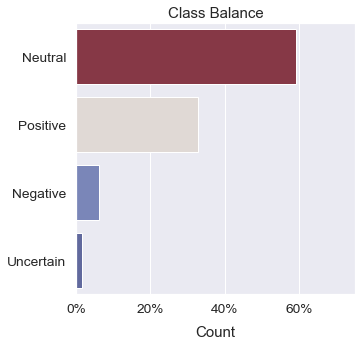

<IPython.core.display.Javascript object>

In [9]:
ax = plotting.countplot(df["emotion"], normalize=True)
ax.set(title="Class Balance")
ax.set_xlim((0, 0.75))

I drop the uncertain category, which doesn't have any clear value. I will have to cope with this imbalance later.

'images\\class_balance.svg'

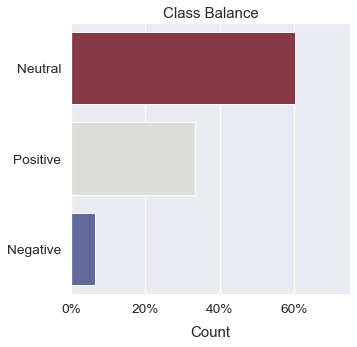

<IPython.core.display.Javascript object>

In [10]:
# Remove 'Uncertain' category
df.emotion.cat.remove_categories("Uncertain", inplace=True)

# Plot class balance
ax = plotting.countplot(df.emotion, normalize=True)
ax.set(title="Class Balance")
ax.set_xlim((0, 0.75))
plotting.save(ax.figure, "images/class_balance.svg")

## Missing Values

According to the table below, there are a lot of missing values in the 'object_of_emotion' category. I bet, however, that these NaN values correspond to the 'Neutral' category. If a tweet doesn't express a brand-emotion, then there shouldn't be any brand in the 'object_of_emotion' column.

There's also one null 'text' row, and a bunch of null 'emotion' rows where the 'Uncertain' category used to be.

In [11]:
cleaning.info(df)

,null,null_%,uniq,uniq_%,dup,dup_%
object_of_emotion,5802,63.81,9,0.10,22,0.24
emotion,156,1.72,3,0.03,22,0.24
text,1,0.01,9065,99.69,22,0.24


<IPython.core.display.Javascript object>

 I'll go ahead and drop the nulls in the 'text' and 'emotion' columns first.

In [12]:
df.dropna(subset=["text", "emotion"], inplace=True)
cleaning.info(df)

,null,null_%,uniq,uniq_%,dup,dup_%
object_of_emotion,5654,63.27,9,0.10,22,0.25
text,0,0.00,8909,99.70,22,0.25
emotion,0,0.00,3,0.03,22,0.25


<IPython.core.display.Javascript object>

In [13]:
null_rows = cleaning.null_rows(df)
lang.readable_sample(null_rows["text"], random_state=9547)

|      | text                                                                                                                                    |
|-----:|:----------------------------------------------------------------------------------------------------------------------------------------|
| 5140 | RT @mention @mention New iPad Apps For Speech Therapy And Communication Are Showcased At #SXSW Conference {link} #sxswi #hcsm #sxswh    |
|  509 | Please RT Follow the next big #college social network @mention chance to win an #iPad at 7,000 followers #socialmedia #SXSW             |
| 4916 | millions of iPhone cases at #SXSW trade show but can any of them double as shuffleboard wax sprinklers? I think not. #fail (CC @mention |
| 6384 | RT @mention not launching any products at #SXSW but we're doing plenty else.  {link}                                                    |
|  790 | Google to Launch Major New Social Network Called Circles, Possibly Today {link} #sxsw&quot;                                             |
| 8793 | Google giving Social another go? {link} Google Circles, let's see what the guys at #SXSW make of it                                     |
| 8452 | @mention The unofficial #SXSW torrents are a great way to hear what you can expect this year {link}                                     |
| 3645 | U gotta fight for yr right to party &amp; to privacy ACLU/google #sxsw #partylikeits1986                                                |
|   61 | #futuremf @mention {link} spec for recipes on the web, now in google search: {link}  #sxsw                                              |
| 4081 | Hope people ask the tough questions. RT @mention Reminder: Android and Chrome TTS talk @mention 1 PM today!  {link}  #sxsw              |

<IPython.core.display.Javascript object>

Looks like some of the NaN values don't line up with the 'Neutral' category. Also, it's important to note that some retweets, e.g. 64, 68, do have sentimental content beyond that of the original tweet.

In [14]:
emotion_without_object = null_rows.loc[null_rows.emotion != "Neutral"]

# Delete variable
del null_rows

display(emotion_without_object.head(), emotion_without_object.shape)

,text,object_of_emotion,emotion
46,Hand-Held ���Hobo�۪: Drafthouse launches ���Ho...,NaN,Positive
64,Again? RT @mention Line at the Apple store is ...,NaN,Negative
68,Boooo! RT @mention Flipboard is developing an ...,NaN,Negative
103,Know that &quot;dataviz&quot; translates to &q...,NaN,Negative
112,Spark for #android is up for a #teamandroid aw...,NaN,Positive


(357, 3)

<IPython.core.display.Javascript object>

In [15]:
lang.readable_sample(
    emotion_without_object.groupby("emotion").get_group("Positive").text,
    random_state=456,
)

|      | text                                                                                                                                           |
|-----:|:-----------------------------------------------------------------------------------------------------------------------------------------------|
| 6606 | RT @mention RT @mention Shiny new @mention @mention @eightbit apps, a new @garyvee book, pop-up iPad 2 stores... #SXSW is Christmas for nerds. |
| 4164 | Mad long line for Google party at Maggie Mae's. Hope it's worth it.. but with 80s theme I am very optimistic #sxsw                             |
| 3020 | Apple offers original iPad donation program {link} #entry #friends #house #sxsw                                                                |
| 8114 | #touchingstories giving us the background to STARTING. Great to hear after yesterday's presos on #uncertainty #iPad and/or #tablet #SXSW       |
|  555 | I have my golden tickets f 4sq party Day after the real party #Redbullbpm with Felix da Housecat playing on iPad! #SXSW  {link}                |
| 5501 | RT @mention At #sxsw even the cabbies are tech savvy. That's his iPhone streaming twitter. @mention  {link}                                    |
| 6676 | RT @mention Soundtrckr featured by @mention @mention as a Must-have for #SXSW {link}                                                           |
|  157 | @mention  #SXSW LonelyPlanet Austin guide for #iPhone is free for a limited time {link} #lp #travel                                            |
| 5019 | Here he comes ladies! @mention  @mention  RT @mention I'll be at Austin Convention Center w/  @mention showing my  iPhone game. #SXSW          |
| 8025 | Someone asks Leo about an iPad 2 at #SXSW, he says 'Email me, I'll send you one free'. O.o                                                     |

<IPython.core.display.Javascript object>

These are positive tweets which are missing a brand label. Many of them seem positive&mdash;some towards a brand and some not. The original features names were 'emotion_in_tweet_is_directed_at' and 'is_there_an_emotion_directed_at_a_brand_or_product', which is not consistent with brandless positivity.

In [16]:
# Create regex for finding each brand
re_apple = r"ipad\s*\d?\s*app|ipad|iphone\s*\d?\s*app|iphone|apple"
re_google = r"android\s*app|android|google"

# Find brand/product name occurrences for each brand
findings = lang.locate_patterns(
    [re_apple, re_google],
    docs=emotion_without_object["text"],
    exclusive=True,
    flags=re.I,
)

# Convert to lowercase
findings = findings.str.lower()

# View results
display(
    findings.value_counts(),
    findings.size,
)

ipad           125
google         122
apple           76
iphone          57
android         19
iphone app       8
ipad app         4
android app      1
Name: locate_patterns, dtype: int64

412

<IPython.core.display.Javascript object>

In [17]:
# Rename Apple apps to match categories defined previously
findings = findings.str.replace(
    r"ipad\s+app|iphone\s+app", "ios app", case=False, regex=True
)

# Fuzzy match with previously defined categories
findings = lang.fuzzy_match(findings, df["object_of_emotion"].cat.categories)

# View results
findings.sort_values("score")

,original,match,score
46,ios app,iOS App,100
6220,iphone,iPhone,100
6202,iphone,iPhone,100
6180,apple,Apple,100
6180,ipad,iPad,100
...,...,...,...
3055,ipad,iPad,100
3055,ipad,iPad,100
3040,ipad,iPad,100
3269,android,Android,100


<IPython.core.display.Javascript object>

In [18]:
# Define sort order, i.e. fill priority
order = [
    "iOS App",
    "Android App",
    "iPhone",
    "iPad",
    "Android",
    "Apple",
    "Google",
]

# Sort values in reverse order
utils.explicit_sort(
    findings,
    order=order,
    by="match",
    ascending=False,
    inplace=True,
)

# Fill in reverse, overwriting lower priority values
for i, brand in findings.match.items():
    df.at[i, "object_of_emotion"] = brand
df.loc[findings.index].sample(10, random_state=4564)

,text,object_of_emotion,emotion
646,���@mention I'll be at the Austin Convention C...,iPhone,Positive
7285,Google showing off google places with hotpot a...,Google,Positive
4870,"Excited to say that I haven't used Foursquare,...",Google,Positive
1805,#sxsw: #15slides: Gruber: keeps on desk Apple ...,Apple,Positive
4976,"@mention Oh, oh, oh! Does the iPad come with m...",iPad,Positive
6996,RT @mention Zazzle is officially at #SXSW! Com...,iPhone,Positive
4536,Whoa - line for ipad2 is 3blks long!!! #apple ...,iPad,Positive
2572,That sounds...fantastic. RT @mention At the Go...,Google,Positive
3861,"Bad news is it costs $1,000? RT @mention Louis...",iOS App,Negative
7990,Apple to sell iPads in &quot;pop-up&quot; Appl...,iPad,Positive


<IPython.core.display.Javascript object>

In [19]:
# Get indices which were not filled
emotion_without_object.drop(findings.index, inplace=True)

# Drop unfilled observations
df.drop(emotion_without_object.index, inplace=True)

print(f"{emotion_without_object.shape[0]} observations dropped.")

del emotion_without_object

24 observations dropped.


<IPython.core.display.Javascript object>

In [20]:
object_without_emotion = df.loc[
    (df.emotion == "Neutral") & df.object_of_emotion.notnull()
]
display(object_without_emotion.head(), object_without_emotion.shape)

,text,object_of_emotion,emotion
63,#Smile RT @mention I think Apple's &quot;pop-u...,Apple,Neutral
265,The #SXSW Apple &quot;pop-up&quot; store was n...,Apple,Neutral
317,I arrived at #sxsw and my @mention issue hasn'...,iOS App,Neutral
558,haha. the google &quot;Party like it's 1986&qu...,Google,Neutral
588,Diller on Google TV: &quot;The first product w...,Other Google Product,Neutral


(91, 3)

<IPython.core.display.Javascript object>

Above are the tweets which are labeled 'Neutral' but have a brand label, implying that a non-neutral emotion is being expressed towards a brand. Most 'Neutral' tweets do not have a brand label, so these 91 tweets are an anomaly.

In [21]:
lang.readable_sample(object_without_emotion["text"], random_state=9547)

|      | text                                                                                                                                                       |
|-----:|:-----------------------------------------------------------------------------------------------------------------------------------------------------------|
| 2477 | Don't need to charge at #sxsw if you're talking in the sun with your iphone: {link} boom!                                                                  |
|   63 | #Smile RT @mention I think Apple's &quot;pop-up store&quot; in Austin would be a lot more interesting if it actually, you know... popped up #sxsw          |
| 4825 | Heading to #sxsw? We're hosting an Android dev meetup, 1:30-2:30pm. Details to follow, but let's plan on geeking out.                                      |
| 8722 | my wife just tried to call my ATT iphone, only 2 have ATT say my number was not working. is #sxsw taking down all ATT networks nationwide?                 |
| 6491 | RT @mention RT @mention &quot;IAVA wants to be the Google of nonprofits.&quot; / yes, we do b/c our #vets deserve nothing less! #sxsw #letshookup          |
| 4728 | Mayer opens it up to questions. Brave girl. More &quot;Google should...&quot; than actual ?s. At least she's accessible. #sxsw                             |
| 6517 | RT @mention RT @mention Best thing I've heard this weekend at #SXSW &quot;I gave my iPad 2 money to #Japan relief. I don't need an iPad 2.&quot; (@mention |
| 6127 | RT @mention In iPad Design Headaches: Take Two Tablets, Call Me in the AM panel - excited to hear @mention live! #sxsw                                     |
| 8045 | New #UberSocial for #iPhone now in the App Store includes UberGuide to #SXSW sponsored by #Mashable {link} by @mention #app                                |
| 5440 | RT @mention Apple likes it if you pay them. That's what Apple likes. - Barry Diller #SXSW                                                                  |

<IPython.core.display.Javascript object>

Since most of them seem neutral to me, and that's consistent with their 'Neutral' label, I'm going to keep them that way.

In [22]:
# Set object to null where emotion is neutral
df.loc[object_without_emotion.index, "object_of_emotion"] = np.nan

# Ensure that 'Neutral' rows line up with 'NaN' rows
(df["emotion"] == "Neutral").equals(df["object_of_emotion"].isnull())

True

<IPython.core.display.Javascript object>

Here's a look at the final distributions.

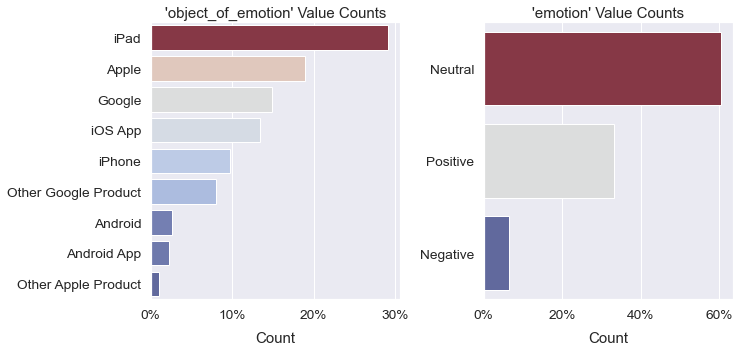

<IPython.core.display.Javascript object>

In [23]:
fig = plotting.countplot(df.select_dtypes("category"), normalize=1)

## Duplicates
There are $22$ duplicate rows, and even more when only the text is considered. I don't want to get rid of all retweets, but I do want to get rid of those which don't have novel content.

In [24]:
cleaning.dup_rows(df.text).sort_values()

7       #SXSW is just starting, #CTIA is around the co...
3962    #SXSW is just starting, #CTIA is around the co...
466        Before It Even Begins, Apple Wins #SXSW {link}
468        Before It Even Begins, Apple Wins #SXSW {link}
9       Counting down the days to #sxsw plus strong Ca...
2559    Counting down the days to #sxsw plus strong Ca...
774     Google to Launch Major New Social Network Call...
776     Google to Launch Major New Social Network Call...
17      I just noticed DST is coming this weekend. How...
8483    I just noticed DST is coming this weekend. How...
2230    Marissa Mayer: Google Will Connect the Digital...
2232    Marissa Mayer: Google Will Connect the Digital...
8747    Need to buy an iPad2 while I'm in Austin at #s...
20      Need to buy an iPad2 while I'm in Austin at #s...
4897    Oh. My. God. The #SXSW app for iPad is pure, u...
21      Oh. My. God. The #SXSW app for iPad is pure, u...
5884    RT @mention Google to Launch Major New Social ...
5882    RT @me

<IPython.core.display.Javascript object>

I filter the text by removing occurrences of 'RT' and then check for duplicates. This should get rid of retweets which are just copies of original tweets in the dataset.

In [25]:
dups = df.text.str.replace(r"\s*RT\s*", "", regex=True).duplicated()
df = df.loc[~dups]
dups.sum()

33

<IPython.core.display.Javascript object>

# Define Stopwords

But before I proceed further, I want to define some stopwords for this particular project.

In [26]:
# SXSW and Twitter stopwords
MY_STOP = frozenset(
    {
        "america",
        "austin",
        "#austin",
        "link",
        "mention",
        "rt",
        "southbysouthwest",
        "sxsw",
        "sxswi",
        "#sxsw",
        "#sxswi",
        "twitter",
        "tweet",
    }
)

# Brand-related stopwords
BRAND_STOP = frozenset(
    {
        "app",
        "androidsxsw",
        "apple",
        "applesxsw",
        "android",
        "google",
        "iphone",
        "ipad",
        "andoid",
    }
)

MY_STOP, BRAND_STOP

(frozenset({'#austin',
            '#sxsw',
            '#sxswi',
            'america',
            'austin',
            'link',
            'mention',
            'rt',
            'southbysouthwest',
            'sxsw',
            'sxswi',
            'tweet',
            'twitter'}),
 frozenset({'andoid',
            'android',
            'androidsxsw',
            'app',
            'apple',
            'applesxsw',
            'google',
            'ipad',
            'iphone'}))

<IPython.core.display.Javascript object>

I save the stopword sets in JSON.

In [27]:
# Create JSON-serializable dict
stopwords = {
    "MY_STOP": list(MY_STOP),
    "BRAND_STOP": list(BRAND_STOP),
}

# Save my stopwords
with open("data/stopwords.json", "w") as f:
    json.dump(stopwords, f)

del stopwords

<IPython.core.display.Javascript object>

# Feature Engineering

In [28]:
# fv = FreqVectorizer(
#     stop_words=MY_STOP,
#     token_pattern=fr"[@#]\b\w'?\w+\b|[{re.escape(string.punctuation)}]{{3,}}",
# )
# fv

<IPython.core.display.Javascript object>

In [29]:
# def build_vocabulary(docs, vect=fv):
#     vect = clone(vect).set_params(use_idf=False, binary=False, norm=None)
#     matrix = vect.fit_transform(docs)
#     counts = np.asarray(matrix.sum(axis=0)).squeeze()
#     doc_freq = np.asarray(matrix.sign().sum(axis=0)).squeeze()
#     vocab = pd.Series(vect.vocabulary_).sort_values()
#     vocab = pd.DataFrame(
#         data=np.vstack([counts, doc_freq]).T,
#         index=vocab.index,
#         columns=["raw_count", "doc_freq"],
#     )
#     vocab["length"] = vocab.index.str.len()
#     vocab["uniq_ratio"] = vocab.index.map(lang.uniq_ratio)
#     return vocab.sort_values("raw_count", ascending=False)

<IPython.core.display.Javascript object>

In [30]:
# build_vocabulary(df["text"])

<IPython.core.display.Javascript object>

In [31]:
# fv.set_params(strip_twitter_handles=True, strip_accents="ascii")

<IPython.core.display.Javascript object>

In [32]:
# vocab = build_vocabulary(df["text"])
# vocab

<IPython.core.display.Javascript object>

In [33]:
# vocab.sort_values("uniq_ratio").head(10)

<IPython.core.display.Javascript object>

In [34]:
# fv.set_params(limit_repeats=True)

<IPython.core.display.Javascript object>

In [35]:
# vocab = build_vocabulary(df["text"])
# vocab.sort_values("uniq_ratio").head(10)

<IPython.core.display.Javascript object>

In [36]:
# bg = lang.stratified_ngrams(
#     df.loc[lambda x: x.emotion != "Neutral"],
#     n=2,
#     text="text",
#     cat="emotion",
#     tokenizer=fv.build_analyzer(),
#     select_best=0.75,
# )
# bg.sort_values("score")

<IPython.core.display.Javascript object>

In [37]:
# vocab = set(vocab.index)
# vocab = {w: i for i, w in enumerate(vocab)}
# vocab

<IPython.core.display.Javascript object>

In [38]:
# fv.set_params(vocabulary=vocab, ngram_range=(1, 2))

<IPython.core.display.Javascript object>

# Modeling

I develop my final model through an iterative process, starting with a basic, baseline version of the model.

Before I do anything, I turn my nested lists of brand terms into strings which can be vectorized. Vectorization is just a convenient way to one-hot-encode them.

## Train-Test-Split

I perform the train-test split which I'll use throughout my modeling process. I let `X` and its derivatives be `DataFrame` objects because I plan to use a `ColumnTransformer` to process the two columns separately.

In [39]:
# Define X and y
X = df["text"].copy()
y = df["emotion"].copy()

# Perform the split
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    random_state=15,
    stratify=y,
    shuffle=True,
)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((6659,), (6659,), (2220,), (2220,))

<IPython.core.display.Javascript object>

<a id='my-freqvectorizer'></a>

### My `FreqVectorizer`

I first create a `ColumnTransformer` to process the data from columns of `X` and concatenate the results.

Inside `col_xform` are two of my `FreqVectorizer` objects. `FreqVectorizer` extends Scikit-Learn's `TfidfVectorizer` and adds a number of powerful preprocessing options. It's called `FreqVectorizer` to emphasize that, like its parent class, it offers several different word-frequency-based vectorization algorithms. Among these algorithms are term frequency (count) vectorization and TF\*IDF (term frequency * inverse document frequency) vectorization. By default, `FreqVectorizer` is set to perform count vectorization.

In `col_xform`, the brand terms ('bra') are effectively one-hot-encoded using default tokenization and `binary=True`. This is how the feature was designed to be encoded. The raw text ('txt') is treated with simple count vectorization as a baseline option.

I'll discuss more details of my `FreqVectorizer` class as they become relevant.

For more information about `FreqVectorizer`, see the help page below.

In [40]:
help(FreqVectorizer)

Help on class FreqVectorizer in module tools.sklearn.vectorizers:

class FreqVectorizer(sklearn.feature_extraction.text.TfidfVectorizer, VectorizerMixin)
 |  FreqVectorizer(*, input='content', encoding='utf-8', decode_error='strict', strip_accents=None, decode_html_entities=True, lowercase=True, strip_extra_space=False, strip_numeric=False, pad_numeric=False, strip_non_word=False, strip_punct=False, strip_twitter_handles=False, strip_html_tags=False, limit_repeats=False, uniq_char_thresh=None, stemmer=None, preprocessor=None, tokenizer=None, token_pattern='\\b\\w\\w+\\b', analyzer='word', stop_words=None, process_stop_words=True, ngram_range=(1, 1), max_df=1.0, min_df=1, max_features=None, vocabulary=None, binary=False, dtype=<class 'numpy.float64'>, norm=None, use_idf=False, smooth_idf=True, sublinear_tf=False)
 |  
 |  Convert a collection of raw documents to a matrix of word-frequency features.
 |  
 |  Extends Scikit-Learn's `TfidfVectorizer` with advanced preprocessing options.
 |

<IPython.core.display.Javascript object>

## Baseline Model: Logistic Regression

I create a `LogisticRegression` classifier. Logistic Regression is my go-to option for classification, and it performs well on this dataset. Since the `y` classes are wildly imbalanced, I set `class_weight='balanced'`. I also hike up `max_iter` because otherwise the model fails to converge.

In [41]:
lr = LogisticRegression(
    class_weight="balanced",
    max_iter=1000,
    solver="newton-cg",
)

lr

LogisticRegression(class_weight='balanced', max_iter=1000, solver='newton-cg')

<IPython.core.display.Javascript object>

I create my main `Pipeline`, consisting simply of `col_xform` and `lr`.

In [42]:
fv = FreqVectorizer(
    strip_accents="ascii", stop_words=MY_STOP, strip_twitter_handles=True
)
fv

FreqVectorizer(stop_words=frozenset({'#austin', '#sxsw', '#sxswi', 'america',
                                     'austin', 'link', 'mention', 'rt',
                                     'southbysouthwest', 'sxsw', 'sxswi',
                                     'tweet', 'twitter'}),
               strip_accents='ascii', strip_twitter_handles=True)

<IPython.core.display.Javascript object>

In [43]:
pipe = Pipeline(
    [
        ("vec", fv),
        ("cls", lr),
    ],
    memory="pipe_cache",
    verbose=True,
)
pipe

Pipeline(memory='pipe_cache',
         steps=[('vec',
                 FreqVectorizer(stop_words=frozenset({'#austin', '#sxsw',
                                                      '#sxswi', 'america',
                                                      'austin', 'link',
                                                      'mention', 'rt',
                                                      'southbysouthwest',
                                                      'sxsw', 'sxswi', 'tweet',
                                                      'twitter'}),
                                strip_accents='ascii',
                                strip_twitter_handles=True)),
                ('cls',
                 LogisticRegression(class_weight='balanced', max_iter=1000,
                                    solver='newton-cg'))],
         verbose=True)

<IPython.core.display.Javascript object>

In [44]:
# Make copy of baseline for future reference
baseline = clone(pipe)

<IPython.core.display.Javascript object>

Looks like `col_xform` is outputting ~8,500 features and ~6,500 samples (i.e. vectors, observations, tweets) with the current settings. The features are words (found in the text) and preset brand terms.

In [45]:
fv.fit_transform(X_train)

<6659x8375 sparse matrix of type '<class 'numpy.float64'>'
	with 90408 stored elements in Compressed Sparse Row format>

<IPython.core.display.Javascript object>

### Fitting the Model

In [46]:
def fit_model(
    estimator, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test
):
    estimator.fit(X_train, y_train)
    print(classification_report(y_test, estimator.predict(X_test)))
    ax = plotting.confusion_matrix(
        estimator,
        X_test,
        y_test,
        labels=estimator.classes_,
        size=(4, 4),
        title_scorer=("accuracy", "f1_macro"),
    )
    return ax

<IPython.core.display.Javascript object>

[Pipeline] ............... (step 1 of 2) Processing vec, total=   0.3s
[Pipeline] ............... (step 2 of 2) Processing cls, total=   0.6s
              precision    recall  f1-score   support

    Negative       0.37      0.50      0.43       141
     Neutral       0.77      0.70      0.73      1343
    Positive       0.57      0.62      0.59       736

    accuracy                           0.66      2220
   macro avg       0.57      0.61      0.58      2220
weighted avg       0.68      0.66      0.67      2220



<AxesSubplot:title={'center':'Accuracy: 0.66, F1 Macro: 0.58'}, xlabel='Predicted Value', ylabel='True Value'>

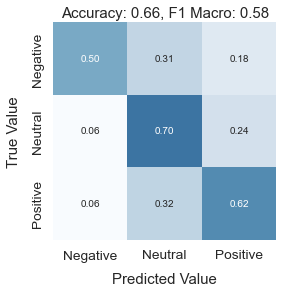

<IPython.core.display.Javascript object>

In [47]:
fit_model(pipe)

Not the best model I've ever seen, but it's a baseline. The text is being count-vectorized, which is a pretty crude strategy. That'll be the first thing to change.

### Compare with Dummy

The baseline, while crude, is much better than the dummy model. This `DummyClassifier` algorithm randomly selects classes with probability weighted according to the class balance. With this dataset, it almost never selects Negative, and it's a 60-30 split between Neutral and Positive.

[Pipeline] ............... (step 2 of 2) Processing cls, total=   0.0s
              precision    recall  f1-score   support

    Negative       0.03      0.04      0.03       141
     Neutral       0.60      0.59      0.59      1343
    Positive       0.34      0.34      0.34       736

    accuracy                           0.47      2220
   macro avg       0.32      0.32      0.32      2220
weighted avg       0.48      0.47      0.47      2220



<AxesSubplot:title={'center':'Accuracy: 0.49, F1 Macro: 0.33'}, xlabel='Predicted Value', ylabel='True Value'>

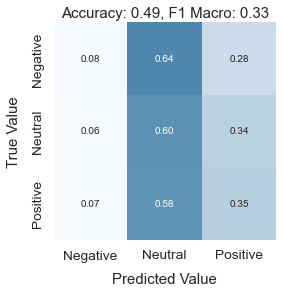

<IPython.core.display.Javascript object>

In [48]:
dummy = DummyClassifier(strategy="stratified")
dummy_pipe = clone(pipe).set_params(cls=dummy)
fit_model(dummy_pipe)

## Select Classifier and Preprocessing

In [49]:
rf = RandomForestClassifier(class_weight="balanced")
lsv = LinearSVC(class_weight="balanced")
sv = SVC(class_weight="balanced")
nb = ComplementNB()
rc = RidgeClassifier(class_weight="balanced")
pc = Perceptron(class_weight="balanced")
pa = PassiveAggressiveClassifier(class_weight="balanced")

<IPython.core.display.Javascript object>

In [50]:
tfidf_grid = {
    "vec__binary": [True, False],
    "vec__norm": ["l2", "l1", None],
    "vec__use_idf": [True, False],
    "vec__sublinear_tf": [True, False],
    "vec__smooth_idf": [True, False],
    "vec__stemmer": ["porter", "wordnet", None],
    "vec__uniq_char_thresh": sp.stats.uniform(0.0, 0.5),
    "vec__max_df": sp.stats.uniform(),
    "vec__min_df": sp.stats.randint(1, 11),
    "vec__ngram_range": [(1, 1), (1, 2)],
    "vec__tokenizer": [
        None,
        nltk.word_tokenize,
        nltk.casual_tokenize,
        nltk.wordpunct_tokenize,
    ],
}

tfidf_grid

{'vec__binary': [True, False],
 'vec__norm': ['l2', 'l1', None],
 'vec__use_idf': [True, False],
 'vec__sublinear_tf': [True, False],
 'vec__smooth_idf': [True, False],
 'vec__stemmer': ['porter', 'wordnet', None],
 'vec__uniq_char_thresh': <scipy.stats._distn_infrastructure.rv_frozen at 0x22b071a9b50>,
 'vec__max_df': <scipy.stats._distn_infrastructure.rv_frozen at 0x22b07fbf130>,
 'vec__min_df': <scipy.stats._distn_infrastructure.rv_frozen at 0x22b071a9f70>,
 'vec__ngram_range': [(1, 1), (1, 2)],
 'vec__tokenizer': [None,
  <function nltk.tokenize.word_tokenize(text, language='english', preserve_line=False)>,
  <function nltk.tokenize.casual.casual_tokenize(text, preserve_case=True, reduce_len=False, strip_handles=False)>,
  <bound method RegexpTokenizer.tokenize of WordPunctTokenizer(pattern='\\w+|[^\\w\\s]+', gaps=False, discard_empty=True, flags=re.UNICODE|re.MULTILINE|re.DOTALL)>]}

<IPython.core.display.Javascript object>

In [51]:
cls_grid = [
    {
        "cls": [lr, pa, sv, lsv],
        "cls__C": sp.stats.loguniform(1e-4, 1e4),
        **tfidf_grid,
    },
    {
        "cls": [nb, rc, pc],
        "cls__alpha": sp.stats.loguniform(1e-4, 1e4),
        **tfidf_grid,
    },
    {
        "cls": [rf],
        "cls__max_depth": sp.stats.randint(1, 10),
        **tfidf_grid,
    },
]
cls_grid

[{'cls': [LogisticRegression(class_weight='balanced', max_iter=1000, solver='newton-cg'),
   PassiveAggressiveClassifier(class_weight='balanced'),
   SVC(class_weight='balanced'),
   LinearSVC(class_weight='balanced')],
  'cls__C': <scipy.stats._distn_infrastructure.rv_frozen at 0x22b0785acd0>,
  'vec__binary': [True, False],
  'vec__norm': ['l2', 'l1', None],
  'vec__use_idf': [True, False],
  'vec__sublinear_tf': [True, False],
  'vec__smooth_idf': [True, False],
  'vec__stemmer': ['porter', 'wordnet', None],
  'vec__uniq_char_thresh': <scipy.stats._distn_infrastructure.rv_frozen at 0x22b071a9b50>,
  'vec__max_df': <scipy.stats._distn_infrastructure.rv_frozen at 0x22b07fbf130>,
  'vec__min_df': <scipy.stats._distn_infrastructure.rv_frozen at 0x22b071a9f70>,
  'vec__ngram_range': [(1, 1), (1, 2)],
  'vec__tokenizer': [None,
   <function nltk.tokenize.word_tokenize(text, language='english', preserve_line=False)>,
   <function nltk.tokenize.casual.casual_tokenize(text, preserve_case=Tru

<IPython.core.display.Javascript object>

In [52]:
if RUN_SWEEPS:
    selection.sweep(
        pipe,
        cls_grid,
        cv_dst="sweeps/classifier_cv.joblib",
        X=X_train,
        y=y_train,
        kind="rand",
        scoring="f1_macro",
        n_jobs=-1,
        n_iter=1000,
    )

<IPython.core.display.Javascript object>

In [53]:
cls_results = joblib.load("sweeps/classifier_cv.joblib")
cls_results = selection.prune_cv(cls_results)
cls_results.head(10)

,param_cls,C,alpha,max_depth,binary,max_df,min_df,ngram_range,norm,smooth_idf,stemmer,sublinear_tf,tokenizer,uniq_char_thresh,use_idf,params,mean_fit_time,mean_score,rank_score
0,"LogisticRegression(class_weight='balanced', ma...",0.001125,NaN,NaN,False,0.526811,2,"(1, 2)",None,False,None,True,<function word_tokenize at 0x0000022B041271F0>,0.334454,True,{'cls': LogisticRegression(class_weight='balan...,4.746000,0.581030,1
1,"LogisticRegression(class_weight='balanced', ma...",0.007988,NaN,NaN,False,0.813393,1,"(1, 1)",None,True,None,True,<function casual_tokenize at 0x0000022B04084EE0>,0.164364,True,{'cls': LogisticRegression(class_weight='balan...,2.142198,0.578970,2
2,SVC(class_weight='balanced'),0.898855,NaN,NaN,True,0.782990,5,"(1, 1)",l2,False,None,False,<bound method RegexpTokenizer.tokenize of Word...,0.211995,False,"{'cls': SVC(class_weight='balanced'), 'cls__C'...",8.517997,0.574688,3
3,"LogisticRegression(class_weight='balanced', ma...",15.302110,NaN,NaN,True,0.419566,2,"(1, 2)",l2,False,None,True,None,0.004763,True,{'cls': LogisticRegression(class_weight='balan...,2.196599,0.572160,4
4,SVC(class_weight='balanced'),0.468613,NaN,NaN,True,0.968165,10,"(1, 1)",l2,False,wordnet,False,<bound method RegexpTokenizer.tokenize of Word...,0.094817,True,"{'cls': SVC(class_weight='balanced'), 'cls__C'...",21.586999,0.571669,5
5,SVC(class_weight='balanced'),1.179322,NaN,NaN,False,0.845276,1,"(1, 1)",None,True,None,True,<function casual_tokenize at 0x0000022B04084EE0>,0.184766,False,"{'cls': SVC(class_weight='balanced'), 'cls__C'...",8.616197,0.571098,6
6,SVC(class_weight='balanced'),0.975539,NaN,NaN,True,0.563026,4,"(1, 2)",None,True,porter,False,<bound method RegexpTokenizer.tokenize of Word...,0.028398,False,"{'cls': SVC(class_weight='balanced'), 'cls__C'...",13.891399,0.570123,7
7,SVC(class_weight='balanced'),0.860330,NaN,NaN,True,0.373484,9,"(1, 1)",l2,True,porter,True,<function word_tokenize at 0x0000022B041271F0>,0.336307,False,"{'cls': SVC(class_weight='balanced'), 'cls__C'...",10.975599,0.568204,8
8,SVC(class_weight='balanced'),0.276656,NaN,NaN,False,0.486918,2,"(1, 1)",l2,False,wordnet,False,<function word_tokenize at 0x0000022B041271F0>,0.408597,True,"{'cls': SVC(class_weight='balanced'), 'cls__C'...",23.769199,0.567984,9
9,LinearSVC(class_weight='balanced'),0.076269,NaN,NaN,False,0.422468,3,"(1, 1)",l2,True,porter,True,<function word_tokenize at 0x0000022B041271F0>,0.455694,True,"{'cls': LinearSVC(class_weight='balanced'), 'c...",4.824597,0.566231,10


<IPython.core.display.Javascript object>

In [54]:
pipe.set_params(**cls_results.loc[0, "params"])

Pipeline(memory='pipe_cache',
         steps=[('vec',
                 FreqVectorizer(max_df=0.526810835155248, min_df=2,
                                ngram_range=(1, 2), smooth_idf=False,
                                stop_words=frozenset({'#austin', '#sxsw',
                                                      '#sxswi', 'america',
                                                      'austin', 'link',
                                                      'mention', 'rt',
                                                      'southbysouthwest',
                                                      'sxsw', 'sxswi', 'tweet',
                                                      'twitter'}),
                                strip_accents='ascii',
                                strip_twitter_handles=True, sublinear_tf=True,
                                tokenizer=<function word_tokenize at 0x0000022B041271F0>,
                                uniq_char_thresh=0.3344538664343174,
  

<IPython.core.display.Javascript object>

### Fitting the Model

C:\Users\ndgig\anaconda3\envs\nlp-env\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['#'] not in stop_words.
  warnings.warn(


[Pipeline] ............... (step 1 of 2) Processing vec, total=   1.8s
[Pipeline] ............... (step 2 of 2) Processing cls, total=   0.7s
              precision    recall  f1-score   support

    Negative       0.36      0.51      0.42       141
     Neutral       0.80      0.73      0.76      1343
    Positive       0.60      0.64      0.62       736

    accuracy                           0.69      2220
   macro avg       0.58      0.63      0.60      2220
weighted avg       0.70      0.69      0.69      2220



<AxesSubplot:title={'center':'Accuracy: 0.69, F1 Macro: 0.60'}, xlabel='Predicted Value', ylabel='True Value'>

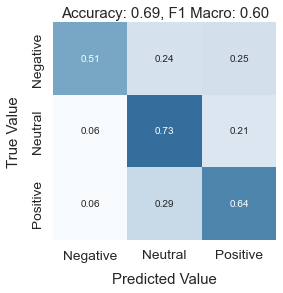

<IPython.core.display.Javascript object>

In [55]:
fit_model(pipe)

## Configure Logistic Regression

I begin by running a search over the `LogisticRegression` hyperparameters. This includes penalty type ('l1', 'l2', 'elasticnet'), regularization strength ('C'), multi-class strategy, whether to fit an intercept, and the solver. I also include the most important `FreqVectorizer` parameters.

In [56]:
lr = LogisticRegressionCV(
    max_iter=1000,
    scoring="f1_macro",
    class_weight="balanced",
    solver="newton-cg",
    fit_intercept=True,
    n_jobs=-1,
)
pipe.set_params(cls=lr)

Pipeline(memory='pipe_cache',
         steps=[('vec',
                 FreqVectorizer(max_df=0.526810835155248, min_df=2,
                                ngram_range=(1, 2), smooth_idf=False,
                                stop_words=frozenset({'#austin', '#sxsw',
                                                      '#sxswi', 'america',
                                                      'austin', 'link',
                                                      'mention', 'rt',
                                                      'southbysouthwest',
                                                      'sxsw', 'sxswi', 'tweet',
                                                      'twitter'}),
                                strip_accents='ascii',
                                strip_twitter_handles=True, sublinear_tf=True,
                                tokenizer=<function word_tokenize at 0x0000022B041271F0>,
                                uniq_char_thresh=0.3344538664343174,
  

<IPython.core.display.Javascript object>

In [57]:
pipe["vec"].set_params(norm="l2")

FreqVectorizer(max_df=0.526810835155248, min_df=2, ngram_range=(1, 2),
               norm='l2', smooth_idf=False,
               stop_words=frozenset({'#austin', '#sxsw', '#sxswi', 'america',
                                     'austin', 'link', 'mention', 'rt',
                                     'southbysouthwest', 'sxsw', 'sxswi',
                                     'tweet', 'twitter'}),
               strip_accents='ascii', strip_twitter_handles=True,
               sublinear_tf=True,
               tokenizer=<function word_tokenize at 0x0000022B041271F0>,
               uniq_char_thresh=0.3344538664343174, use_idf=True)

<IPython.core.display.Javascript object>

C:\Users\ndgig\anaconda3\envs\nlp-env\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['#'] not in stop_words.
  warnings.warn(


[Pipeline] ............... (step 1 of 2) Processing vec, total=   1.7s
[Pipeline] ............... (step 2 of 2) Processing cls, total=  11.3s
              precision    recall  f1-score   support

    Negative       0.38      0.51      0.44       141
     Neutral       0.80      0.72      0.76      1343
    Positive       0.59      0.66      0.62       736

    accuracy                           0.69      2220
   macro avg       0.59      0.63      0.61      2220
weighted avg       0.70      0.69      0.69      2220



<AxesSubplot:title={'center':'Accuracy: 0.69, F1 Macro: 0.61'}, xlabel='Predicted Value', ylabel='True Value'>

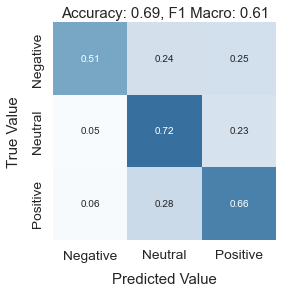

<IPython.core.display.Javascript object>

In [58]:
fit_model(pipe)

### My `sweep` Function

My `selection.sweep` function is a generic function for searching parameter spaces using Scikit-Learn. If you pass `kind='grid'`, it fits a `GridSearchCV`, running an exhaustive search over every combination of parameters. This is the default (and most thorough) option. You can also pass `kind='rand'` to fit a `RandomizedSearchCV`, which searches a random sample of the parameter space. If you want to speed things up, you can pass `kind='hgrid'` or `kind='hrand'` to fit Scikit-Learn's experimental `HalvingGridSearchCV` or its randomized counterpart. The "halving" searches try to weed out the weak candidates using only a small amount of computational resources (e.g. a small sample of the data).

Rather than returning a `GridSearchCV` object or equivalent, `selection.sweep` immediately serializes the search estimator and saves it via `joblib`. This is done to prevent loss of the search results. It's very easy to load a serialized search estimator, and I have a function `selection.load_results` which trims down the `cv_results_` and returns a `DataFrame`.

Constructing document vectors with raw **term frequencies** is a very crude approach. Words like 'the', if not filtered out, will have a high frequency in many tweets. But 'the' contains no information about the tweet's overall content. The TF\*IDF algorithm addresses this problem by normalizing term frequencies according to **inverse document frequency**. A term's inverse document frequency is the (logarithmically scaled) number of documents in the corpus divided by the number of documents containing the term. It represents the rarity of a term.

I lay out the TF\*IDF parameters which determine whether `FreqVectorizer` produces binary occurrence vectors, count vectors, normalized occurrence vectors, or normalized TF\*IDF vectors. The 'norm' often strongly affects model quality, so I've included that too.

<a id='add-vadervectorizer'></a>

## Add `VaderVectorizer`

I add a new vectorizer to the mix which performs VADER (Valence Aware Dictionary and sEntiment Reasoner) analysis on each tweet and returns the polarity scores as vectors.

In [59]:
fu = FeatureUnion(
    [
        ("frq", pipe["vec"]),
        ("vad", VaderVectorizer()),
    ],
    verbose=True,
)
fu

FeatureUnion(transformer_list=[('frq',
                                FreqVectorizer(max_df=0.526810835155248,
                                               min_df=2, ngram_range=(1, 2),
                                               norm='l2', smooth_idf=False,
                                               stop_words=frozenset({'#austin',
                                                                     '#sxsw',
                                                                     '#sxswi',
                                                                     'america',
                                                                     'austin',
                                                                     'link',
                                                                     'mention',
                                                                     'rt',
                                                                     'southbysouthwest',
                  

<IPython.core.display.Javascript object>

In [60]:
pipe = Pipeline(
    [("vec", fu), ("nrm", Normalizer()), ("cls", lr)],
    memory="pipe_cache",
    verbose=True,
)

<IPython.core.display.Javascript object>

C:\Users\ndgig\anaconda3\envs\nlp-env\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['#'] not in stop_words.
  warnings.warn(


[FeatureUnion] ........... (step 1 of 2) Processing frq, total=   1.6s
[FeatureUnion] ........... (step 2 of 2) Processing vad, total=   1.1s
[Pipeline] ............... (step 1 of 3) Processing vec, total=   2.7s
[Pipeline] ............... (step 3 of 3) Processing cls, total=  11.9s
              precision    recall  f1-score   support

    Negative       0.40      0.64      0.49       141
     Neutral       0.81      0.71      0.76      1343
    Positive       0.61      0.68      0.64       736

    accuracy                           0.70      2220
   macro avg       0.61      0.68      0.63      2220
weighted avg       0.72      0.70      0.70      2220



<AxesSubplot:title={'center':'Accuracy: 0.70, F1 Macro: 0.63'}, xlabel='Predicted Value', ylabel='True Value'>

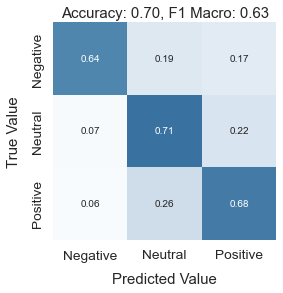

<IPython.core.display.Javascript object>

In [61]:
fit_model(pipe)

## Refit with Final Parameters

In [62]:
pipe.fit(X, y)

C:\Users\ndgig\anaconda3\envs\nlp-env\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['#'] not in stop_words.
  warnings.warn(


[FeatureUnion] ........... (step 1 of 2) Processing frq, total=   2.6s
[FeatureUnion] ........... (step 2 of 2) Processing vad, total=   1.7s
[Pipeline] ............... (step 1 of 3) Processing vec, total=   4.3s
[Pipeline] ............... (step 3 of 3) Processing cls, total=  16.6s


Pipeline(memory='pipe_cache',
         steps=[('vec',
                 FeatureUnion(transformer_list=[('frq',
                                                 FreqVectorizer(max_df=0.526810835155248,
                                                                min_df=2,
                                                                ngram_range=(1,
                                                                             2),
                                                                norm='l2',
                                                                smooth_idf=False,
                                                                stop_words=frozenset({'#austin',
                                                                                      '#sxsw',
                                                                                      '#sxswi',
                                                                                      'america',
                       

<IPython.core.display.Javascript object>

# Interpretation

The first order of business is to label the coefficients.

In [63]:
feat_names = pipe["vec"].get_feature_names_out(None)
feat_names = np.array(feat_names)

classes = pipe["cls"].classes_
coef = pd.DataFrame(pipe["cls"].coef_, columns=feat_names, index=classes).T

coef.sort_values("Negative", ascending=False)

,Negative,Neutral,Positive
frq__not,4.157446,-1.213222,-2.944225
frq__n't,4.070885,-1.831369,-2.239517
frq__design_headaches,3.718803,-1.723856,-1.994947
frq__headaches,3.644237,-1.752930,-1.891307
frq__long,3.161694,-1.595636,-1.566058
...,...,...,...
frq__free,-2.238302,2.653626,-0.415325
frq__party,-2.356758,2.118269,0.238489
frq__{_},-2.557715,2.464100,0.093615
frq__{,-2.570424,2.455772,0.114652


<IPython.core.display.Javascript object>

## Top 25 Overall
Then I examine the 25 coefficients with the largest magnitude.

In [64]:
top25 = coef.abs().max(axis=1).sort_values().tail(25).index
top25

Index(['frq__news_apps', 'frq__free', 'frq__why', 'frq__?', 'frq__is',
       'frq__already', 'frq__ipad_news', 'frq__.', 'frq__hate', 'frq__#_fail',
       'frq__because', 'frq__enough', 'frq__app', 'frq__apps', 'frq__iphone',
       'frq__fail', 'frq__long', 'frq__&', 'frq__cool', 'frq__headaches',
       'frq__ipad', 'frq__design_headaches', 'frq__n't', 'frq__not', 'frq__!'],
      dtype='object')

<IPython.core.display.Javascript object>

Most of the top 25 coefficients are from the TF\*IDF word vectors, unsurprisingly. As predicted, '!' shows up as a top positive coefficient. Another notable top positive term is 'ipad'. Punctuation and very common stopword-like words are related to 'Neutral'.

'images\\top25_coef.svg'

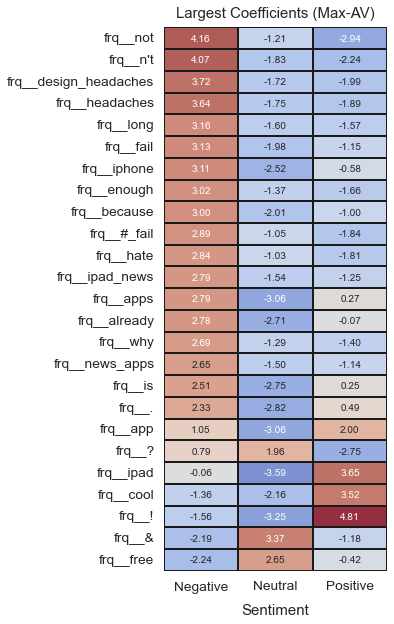

<IPython.core.display.Javascript object>

In [65]:
fig, ax = plt.subplots(figsize=(4, 10))
hm_style = dict(plotting.HEATMAP_STYLE)
del hm_style["square"]

sns.heatmap(
    coef.loc[top25].sort_values("Negative", ascending=False),
    ax=ax,
    square=False,
    **hm_style,
)

ax.set(xlabel="Sentiment")
ax.set_title("Largest Coefficients (Max-AV)", pad=10)
plotting.save(fig, "images/top25_coef.svg")

## Calculating a Composite Score

I calculate a composite score for each feature in order to compare them more easily. My composite score is a function of the positive $p$, negative $n$, and neutral $u$ coefficient vectors:

$$c(p, n, u) = \frac{p-n}{s(u)}$$

Where $s$ is a min-max-scaling function that scales vectors to the interval $[1, 2]$. The scaling function is defined as follows for a vector $v$:

$$s(v)={\frac{v-v_{min}}{v_{max}-v_{min}}+1}$$

The idea is to pull the score towards zero according to the degree of neutrality. The divisor will be 2 for the most neutral feature (resulting in the mean of $p_{i}$ and $-n_{i}$), and 1 for the least neutral (resulting in simply $p_{i}-n_{i}$). This allows the neutral vector to contribute without carrying too much weight.

In [66]:
def composite(coef_df):
    neut = minmax_scale(coef_df["Neutral"], feature_range=(1, 2))
    return (coef_df["Positive"] - coef_df["Negative"]) / neut

<IPython.core.display.Javascript object>

In [67]:
coef["Composite"] = composite(coef)
coef.sort_values("Composite")

,Negative,Neutral,Positive,Composite
frq__not,4.157446,-1.213222,-2.944225,-5.295502
frq__n't,4.070885,-1.831369,-2.239517,-5.039164
frq__design_headaches,3.718803,-1.723856,-1.994947,-4.507117
frq__headaches,3.644237,-1.752930,-1.891307,-4.380979
frq__long,3.161694,-1.595636,-1.566058,-3.675930
...,...,...,...,...
frq__genius,-0.247959,-2.392579,2.640538,2.465329
frq__new,-1.135116,-1.220770,2.355886,2.605242
frq__ipad,-0.063665,-3.587377,3.651043,3.714708
frq__cool,-1.355138,-2.162370,3.517508,4.044632


<IPython.core.display.Javascript object>

Text(0.5, 1.0, 'Largest Coefficients with Composite')

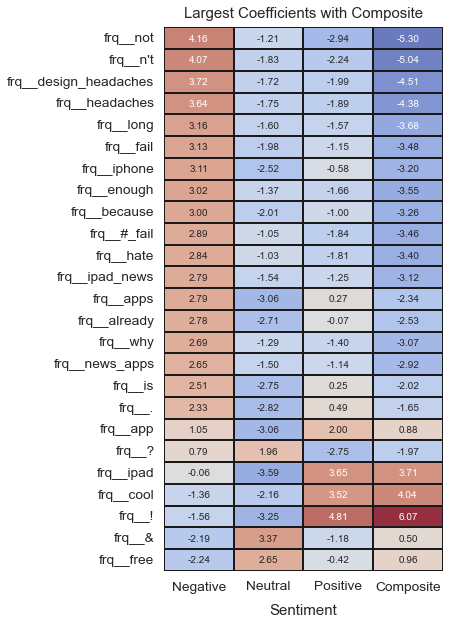

<IPython.core.display.Javascript object>

In [68]:
fig, ax = plt.subplots(figsize=(5, 10))
sns.heatmap(
    coef.loc[top25].sort_values("Negative", ascending=False),
    square=False,
    ax=ax,
    **hm_style,
)
ax.set(xlabel="Sentiment")
ax.set_title("Largest Coefficients with Composite", pad=10)

## TF\*IDF Words

The TF\*IDF features were the most influential overall. While the unigram term coefficients from the model are not *completely* useless for brand-related research, they are too coarse-grained and simplistic. See my EDA notebook ([exploratory.ipynb](exploratory.ipynb)) for a deeper brand-related examination of TF\*IDF keywords.

In [69]:
term_coef = coef.filter(regex="^frq__", axis=0).copy()
term_coef.index = term_coef.index.str.replace("frq__", "").str.replace("_", " ")
term_coef.sort_values("Positive", ascending=False)

,Negative,Neutral,Positive,Composite
!,-1.556011,-3.250085,4.806097,6.068074
ipad,-0.063665,-3.587377,3.651043,3.714708
cool,-1.355138,-2.162370,3.517508,4.044632
genius,-0.247959,-2.392579,2.640538,2.465329
new,-1.135116,-1.220770,2.355886,2.605242
...,...,...,...,...
headaches,3.644237,-1.752930,-1.891307,-4.380979
design headaches,3.718803,-1.723856,-1.994947,-4.507117
n't,4.070885,-1.831369,-2.239517,-5.039164
?,0.789149,1.957209,-2.746358,-1.967947


<IPython.core.display.Javascript object>

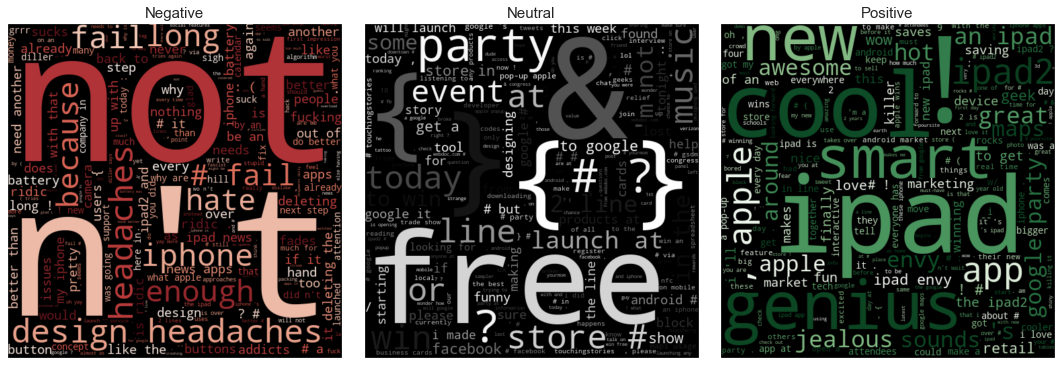

<IPython.core.display.Javascript object>

In [70]:
fig = plotting.wordcloud(
    term_coef.drop("Composite", axis=1),
    cmap=dict(Negative="Reds", Neutral="Greys", Positive="Greens"),
    size=(5, 5),
    desat=0.7,
    random_state=35,
)
fig.savefig(normpath("images/txt_coef_wordclouds.svg"), bbox_inches="tight")
fig.savefig(normpath("images/txt_coef_wordclouds.png"), bbox_inches="tight")

The terms in both the 'Positive' and 'Negative' wordclouds make good sense, and many of them such as 'iphon' and 'batteri' show up in the EDA wordclouds. The Neutral category is associated with punctuation and very common (stopword-like) words. That explains why no stopwords were selected.

In [71]:
apple_terms = term_coef.filter(regex="apple|ipad|iphone", axis=0).copy()
apple_terms

,Negative,Neutral,Positive,Composite
! apple,-0.634745,-0.278649,0.913394,1.049345
! ipad,-0.099517,-0.180507,0.280024,0.254822
! iphone,-0.201380,0.180476,0.020904,0.144219
# apple,-0.504112,-0.271297,0.775409,0.866652
# apple store,-0.047313,-0.331450,0.378763,0.290291
...,...,...,...,...
yur ipad,-0.053422,0.109474,-0.056052,-0.001717
zazzle ipad,-0.020829,0.246538,-0.225709,-0.132113
} apple,-0.025032,0.024451,0.000581,0.016864
} ipad,0.731538,-0.372476,-0.359062,-0.746036


<IPython.core.display.Javascript object>

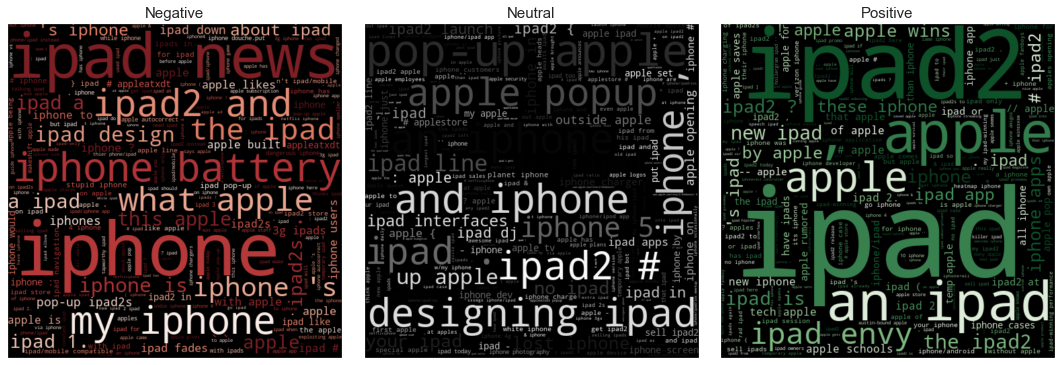

<IPython.core.display.Javascript object>

In [72]:
fig = plotting.wordcloud(
    apple_terms.loc[:, ["Negative", "Neutral", "Positive"]],
    cmap=dict(Negative="Reds", Neutral="Greys", Positive="Greens"),
    size=(5, 5),
    ncols=3,
    desat=0.7,
    random_state=53,
)
fig.savefig(normpath("images/apple_coef_wordclouds.svg"), bbox_inches="tight")
fig.savefig(normpath("images/apple_coef_wordclouds.png"), bbox_inches="tight")

In [73]:
type(plt.get_cmap("Set1"))

matplotlib.colors.ListedColormap

<IPython.core.display.Javascript object>

[Text(0.5, 0, 'Composite Score')]

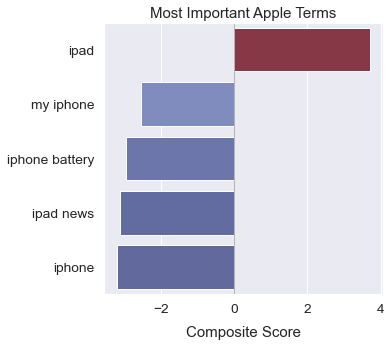

<IPython.core.display.Javascript object>

In [80]:
ax = plotting.heated_barplot(
    data=apple_terms.loc[lambda x: x.abs().nlargest(5, "Composite").index, "Composite"],
    figsize=(5, 5),
)

ax.set_title("Most Important Apple Terms", pad=5)
ax.set(xlabel="Composite Score")

In [75]:
punct_coef = term_coef.filter(regex="^\W+$", axis=0).copy()
punct_coef

,Negative,Neutral,Positive,Composite
!,-1.556011,-3.250085,4.806097,6.068074
! !,0.075306,-0.590844,0.515538,0.307750
! #,-1.254430,-0.224712,1.479142,1.843163
! &,-0.080184,0.225057,-0.144873,-0.041797
! '',0.119985,-0.035247,-0.084738,-0.135551
...,...,...,...,...
} |,-0.055993,0.265401,-0.209408,-0.098755
} ~,-0.136873,-0.195886,0.332759,0.315776
~,-0.371520,0.234129,0.137390,0.328540
~ #,-0.122697,0.232384,-0.109687,0.008401


<IPython.core.display.Javascript object>

[Text(0.5, 0, 'Composite Score'), Text(0, 0.5, 'Term')]

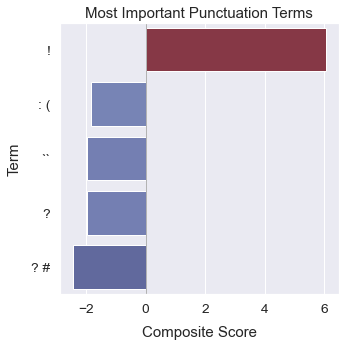

<IPython.core.display.Javascript object>

In [76]:
ax = plotting.heated_barplot(
    data=punct_coef.loc[lambda x: x.abs().nlargest(5, "Composite").index, "Composite"],
    figsize=(5, 5),
)
ax.set_title("Most Important Punctuation Terms", pad=5)
ax.set(xlabel="Composite Score", ylabel="Term")

I create a color palette for the three classes and a function for making positive vs. negative coefficient plots.

## VADER Valence
Here are the VADER coefficients. They are relatively large, as expected. Adding VADER vectors to the mix proved to be a good idea.

In [77]:
vad_coef = coef.filter(regex="^vad__", axis=0).copy()
# vad_coef.drop("Composite", axis=1, inplace=True)
vad_coef.index = vad_coef.index.str.replace("vad__", "").str.capitalize()
vad_coef

,Negative,Neutral,Positive,Composite
Neg,2.439356,-1.858103,-0.581253,-2.419524
Neu,-0.801905,1.356802,-0.554897,0.144425
Pos,1.410233,-1.333825,-0.076408,-1.123053
Compound,-1.516754,0.050032,1.466722,1.959516


<IPython.core.display.Javascript object>

[Text(17.099999999999998, 0.5, 'VADER Score'),
 Text(0.5, 13.109375, 'Model Coefficient')]

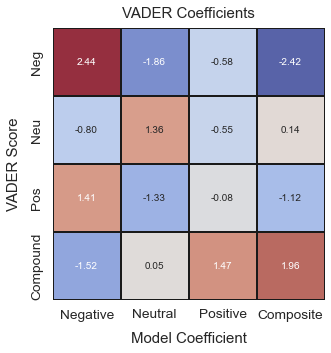

<IPython.core.display.Javascript object>

In [78]:
fig, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(data=vad_coef, square=True, **hm_style)
ax.set_title("VADER Coefficients", pad=10)
ax.set(ylabel="VADER Score", xlabel="Model Coefficient")

The two most important VADER features were 'Neg' and 'Compound'. Unsurprisingly, 'Neg' had a strong association with Negative and a strong inverse association with Positive. 'Compound' is a summary of the other three scores which is enhanced with additional rules. It's not surprising that it had such a robust association with Positive and an inverse association with Negative. 'Neu' and 'Pos' had lackluster importance.

# Recommendations

See [exploratory.ipynb](exploratory.ipynb) for the investigation which led to my recommendations.

#### 1. Try to shake your authoritarian image by ostensibly allowing end-users more freedom.

People like that Apple products just work out of the box, but they find your paternalistic approach to managing your products off-putting. **Send the message** that when you buy an Apple product, you are free to do what you want with it. Keep control over the most important things, but relinquish control over the less important things. Make people feel like they have the freedom to customize your products as they see fit. Make some concessions to placate the majority, while allowing the elite techno-snobs to continue complaining on the fringe.

#### 2. Do something to improve the iPhone's battery life and turn it into a marketing campaign.

There were a lot complaints about the iPhone's battery life. One user suggested that their Blackberry was doing much better. There were also complaints about #batterykiller apps which use geolocation in the background. If you made a big publicized effort to increase the iPhone's battery life, that would get people excited.

#### 3. Open another temporary popup store for your next big product launch.

The iPad 2 popup store was a roaring success, and people couldn't stop talking about it. Terms like 'shiny new', 'jealous', and 'cool technology' were closely associated with the iPad 2 and popup store.

# Future Work
### Stacking Classifiers
After experimenting a little with Scikit-Learn's `StackingClassifier`, it's become clear that I could use it to develop a more accurate final model. The `StackingClassifier` trains several classifiers on the data and then trains a final classifier on the concatenated output of those classifiers. It also allows you to pass the training data to your final estimator, so the final estimator is trained both on prior data and the predictions of the classifier ensemble.

### Sophisticated Vectorization
I experimented some with Doc2Vec, a sophisticated unsupervised document vectorization algorithm, but didn't find it to offer any advantage over `FreqVectorizer` when trained on this small dataset. It proved to be slower, much more complicated, and much less interpretable. However, if trained on a large corpus of tweets, and then used to predict vectors for the present dataset, it could prove to be better than TF\*IDF vectorization. Even if the Doc2Vec vectors didn't turn out to be better than the TF\*IDF vectors, they could potentially augment them. A Doc2Vec model trained on a large corpus would probably contribute **novel information**.

# Conclusion

I created an accurate model, at around 0.66 balanced accuracy. The dataset is small, noisy, and not particularly well labeled. Nevertheless, I'm confident that I can increase the accuracy by stacking classifiers. I'd also like to try alternative methods of vectorization, but I'm not as confident that it will improve the model.

Through interpreting my model and conducting a brief exploratory analysis in [exploratory.ipynb](exploratory.ipynb), I arrived at three recommendations. First, you should publicly relinquish a small amount of control over your products to send the message that you care about individual freedom (and aren't a "fascist company"). Second, you should improve the iPhone's battery life and turn that into a rallying point for a marketing campaign. People are really concerned about the iPhone's battery life. Third, you should repeat the temporary popup store for your next big product launch. There was an overwhelming amount of chatter about the iPad 2 popup store.